#Sentiment Analysis of Amazon Musical Instruments Reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Data Inspecting and Preprocessing

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Instruments_Reviews.csv to Instruments_Reviews.csv


In [3]:
# Loading the dataset
file_path = 'Instruments_Reviews.csv'
dataset = pd.read_csv(file_path)
dataset.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [4]:
dataset.isnull().sum()

,0
reviewerID,0
asin,0
reviewerName,27
helpful,0
reviewText,7
overall,0
summary,0
unixReviewTime,0
reviewTime,0


In [5]:
dataset.reviewText.fillna(value = "", inplace = True)

In [6]:
dataset["reviews"] = dataset["reviewText"] + " " + dataset["summary"]
dataset.drop(columns = ["reviewText", "summary"], axis = 1, inplace = True)

In [7]:
dataset.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014","Not much to write about here, but it does exac..."
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",The product does exactly as it should and is q...
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",The primary job of this device is to block the...
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",Nice windscreen protects my MXL mic and preven...
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",This pop filter is great. It looks and perform...


In [8]:
dataset.describe(include = "all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10261
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013","Not much to write about here, but it does exac..."
freq,42,163,66,6796,NaN,NaN,40,1
mean,NaN,NaN,NaN,NaN,4.488744,1.360606e+09,NaN,NaN
std,NaN,NaN,NaN,NaN,0.894642,3.779735e+07,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN


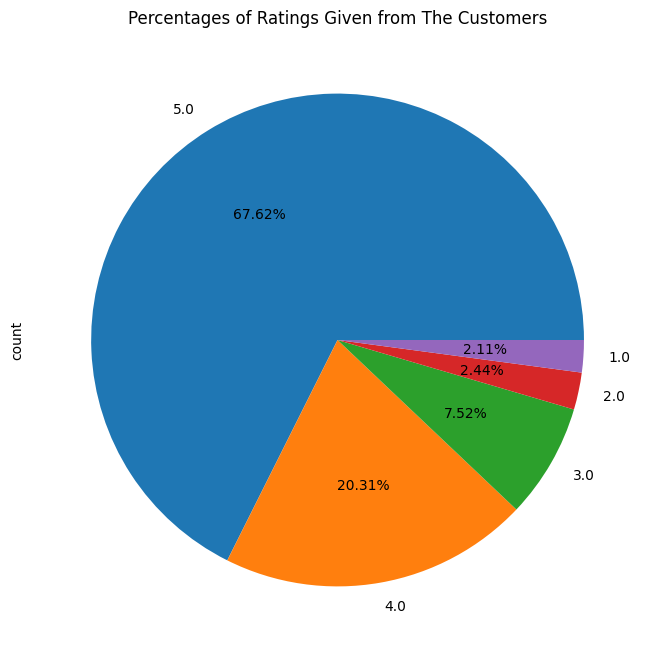

In [ ]:
dataset.overall.value_counts().plot(kind = "pie", legend = False, autopct = "%1.2f%%", fontsize = 10, figsize=(8,8))
plt.title("Percentages of Ratings Given from The Customers", loc = "center")
plt.show()

 We will categorize each sentiment according to ratings given for each row based on the explanation before: Positive Label for products with rating bigger than 3.0, Neutral Label for products with rating equal to 3.0, else Negative Label.

In [9]:
def Labelling(Rows):
  if(Rows["overall"] > 3.0):
    Label = "Positive"
  elif(Rows["overall"] < 3.0):
    Label = "Negative"
  else:
    Label = "Neutral"
  return Label

In [10]:
dataset["sentiment"] = dataset.apply(Labelling, axis = 1)

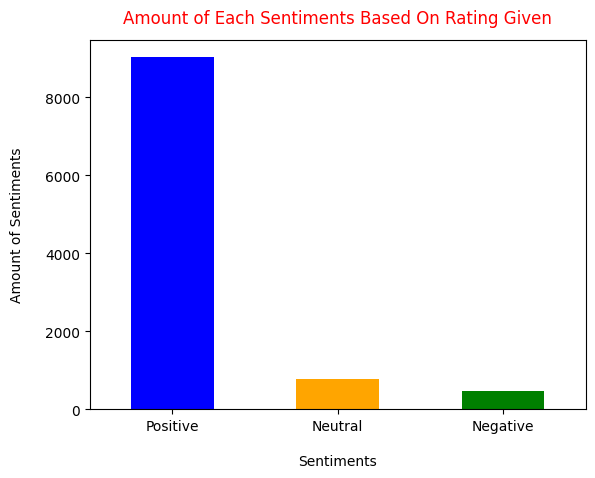

In [11]:
# Plotting the histogram with different colors for each bar
colors = ["blue", "orange", "green", "red", "purple", "brown"]
dataset['sentiment'].value_counts().plot(kind='bar', color=colors)

# Adding the title and labels with customization
plt.title("Amount of Each Sentiments Based On Rating Given", loc="center", fontsize=12, color="red", pad=12)
plt.xlabel("Sentiments", color="black", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Amount of Sentiments", color="black", fontsize=10, labelpad=15)

# Display the plot
plt.show()

##Text Preprocessing

In [12]:
def Text_Cleaning(Text):
  # Lowercase the texts
  Text = Text.lower()

  # Cleaning punctuations in the text
  punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  Text = Text.translate(punc)

  # Removing numbers in the text
  Text = re.sub(r'\d+', '', Text)

  # Remove possible links
  Text = re.sub('https?://\S+|www\.\S+', '', Text)

  # Deleting newlines
  Text = re.sub('\n', '', Text)

  return Text

In [13]:
# Stopwords
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

def Text_Processing(Text):
  Processed_Text = list()
  Lemmatizer = WordNetLemmatizer()

  # Tokens of Words
  Tokens = nltk.word_tokenize(Text)

  # Removing Stopwords and Lemmatizing Words
  # To reduce noises in our dataset, also to keep it simple and still
  # powerful, we will only omit the word `not` from the list of stopwords

  for word in Tokens:
    if word not in Stopwords:
      Processed_Text.append(Lemmatizer.lemmatize(word))

  return(" ".join(Processed_Text))

In [14]:
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Cleaning(Text))
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Processing(Text))

##Exploratory Data Analysis

In [15]:
dataset.head(n = 10)

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014",not much write exactly supposed filter pop sou...,Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",product exactly quite affordable not realized ...,Positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",primary job device block breath would otherwis...,Positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",nice windscreen protects mxl mic prevents pop ...,Positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",pop filter great look performs like studio fil...,Positive
5,A2A039TZMZHH9Y,B00004Y2UT,"Bill Lewey ""blewey""","[0, 0]",5.0,1356048000,"12 21, 2012",good bought another one love heavy cord gold c...,Positive
6,A1UPZM995ZAH90,B00004Y2UT,Brian,"[0, 0]",5.0,1390089600,"01 19, 2014",used monster cable year good reason lifetime w...,Positive
7,AJNFQI3YR6XJ5,B00004Y2UT,"Fender Guy ""Rick""","[0, 0]",3.0,1353024000,"11 16, 2012",use cable run output pedal chain input fender ...,Neutral
8,A3M1PLEYNDEYO8,B00004Y2UT,"G. Thomas ""Tom""","[0, 0]",5.0,1215302400,"07 6, 2008",perfect epiphone sheraton ii monster cable wel...,Positive
9,AMNTZU1YQN1TH,B00004Y2UT,Kurt Robair,"[0, 0]",5.0,1389139200,"01 8, 2014",monster make best cable lifetime warranty does...,Positive


In [16]:
dataset.describe(include = "all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10254,3
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013",good string five star,Positive
freq,42,163,66,6796,NaN,NaN,40,3,9022
mean,NaN,NaN,NaN,NaN,4.488744,1.360606e+09,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.894642,3.779735e+07,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN,NaN


### Polarity, Review Length, and Word Counts

####Polarity

In [17]:
dataset["polarity"] = dataset["reviews"].map(lambda Text: TextBlob(Text).sentiment.polarity)

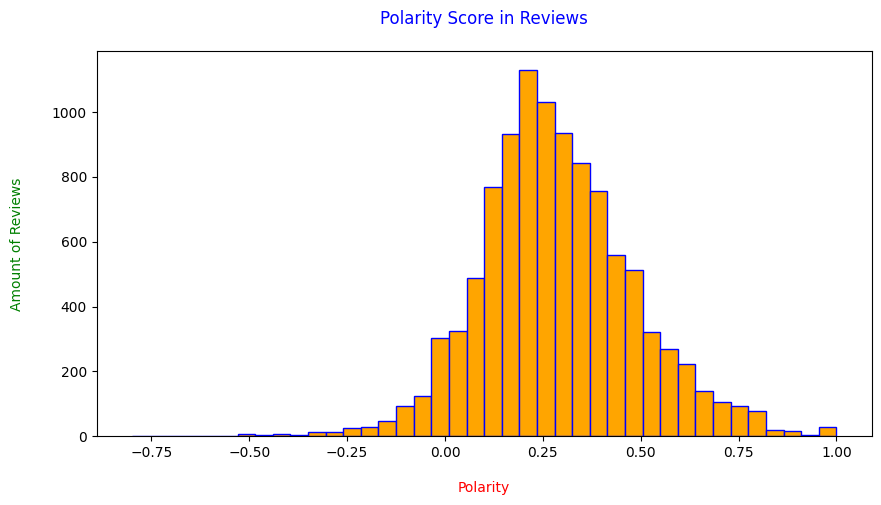

In [18]:
dataset["polarity"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Polarity Score in Reviews", color = "blue", pad = 20)
plt.xlabel("Polarity", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

####Review Length

In [19]:
dataset["length"] = dataset["reviews"].astype(str).apply(len)

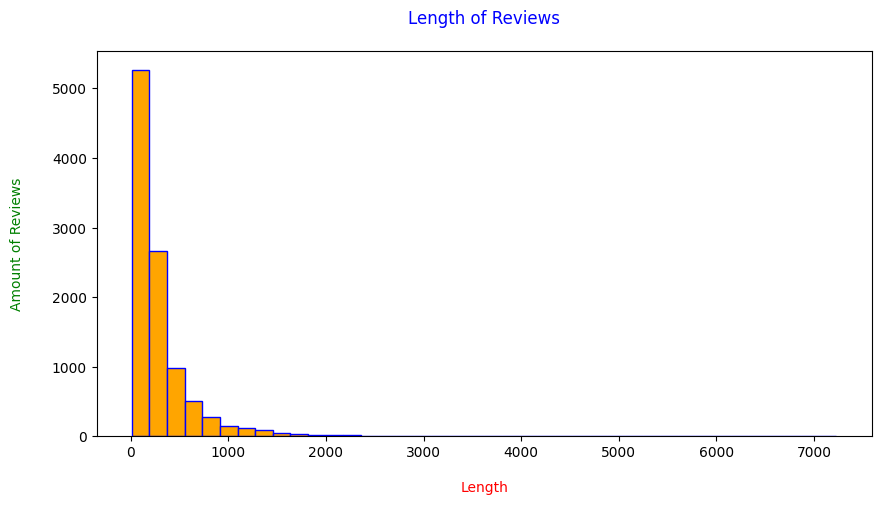

In [20]:
dataset["length"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Length of Reviews", color = "blue", pad = 20)
plt.xlabel("Length", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

####Word Counts

In [21]:
dataset["word_counts"] = dataset["reviews"].apply(lambda x: len(str(x).split()))

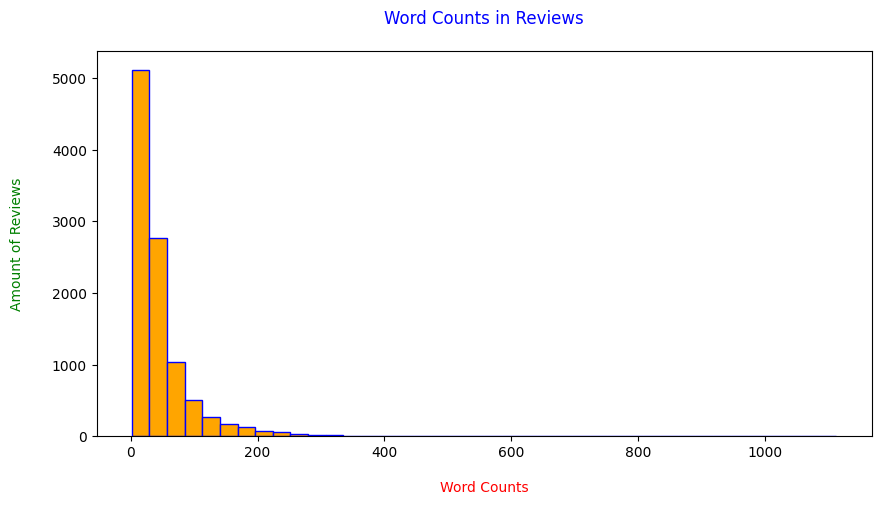

In [22]:
dataset["word_counts"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Word Counts in Reviews", color = "blue", pad = 20)
plt.xlabel("Word Counts", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

###N-Gram Analysis

In [30]:
def Gram_Analysis(Corpus, Gram, N):
  # Vectorizer
  # Change Stopwords to a list if it's currently a set
  stop_words_list = list(Stopwords) if isinstance(Stopwords, set) else Stopwords
  Vectorizer = CountVectorizer(stop_words=stop_words_list, ngram_range=(Gram,Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key = lambda x:x[1], reverse = True)

  return words[:N]

In [31]:
# Use dropna() so the base DataFrame is not affected
Positive = dataset[dataset["sentiment"] == "Positive"].dropna()
Neutral = dataset[dataset["sentiment"] == "Neutral"].dropna()
Negative = dataset[dataset["sentiment"] == "Negative"].dropna()

####Unigram of Reviews Based on Sentiments

##### Positive Sentiment

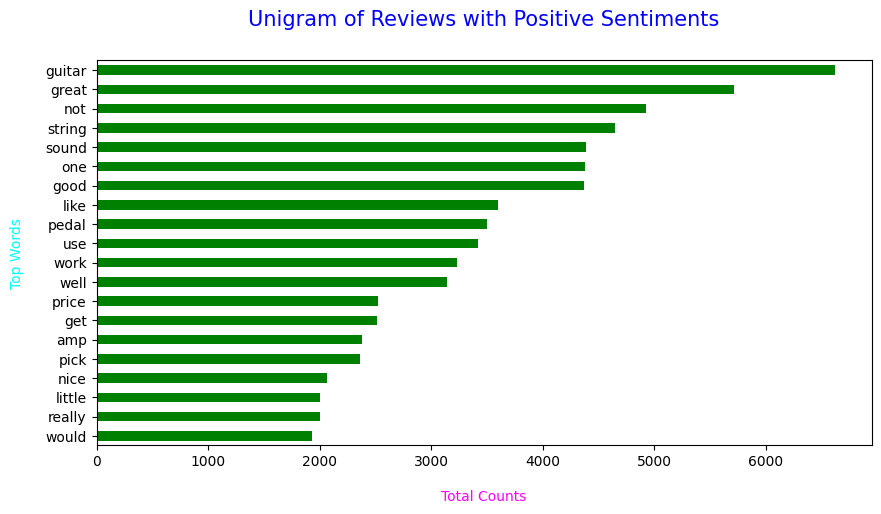

In [32]:
# Finding Unigram
words = Gram_Analysis(Positive["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Unigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

#####Neutral Sentiment

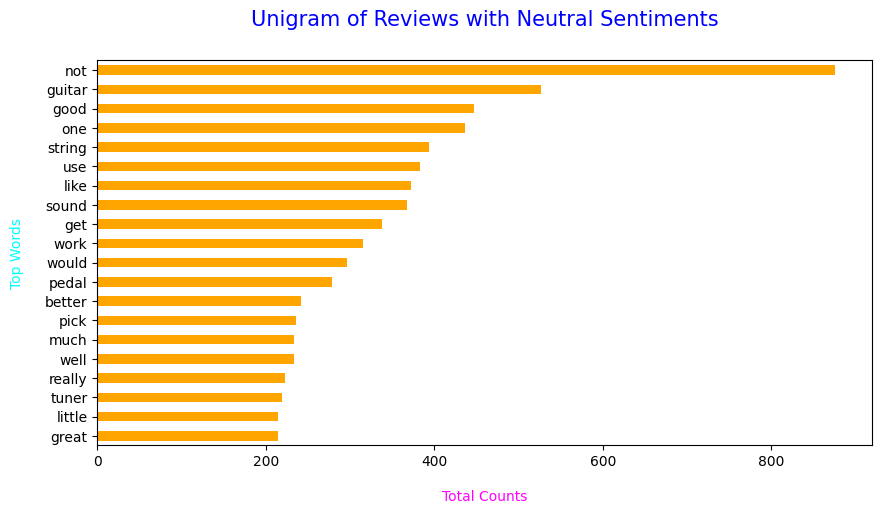

In [33]:
# Finding Unigram
words = Gram_Analysis(Neutral["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Unigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

#####Negative Sentiment

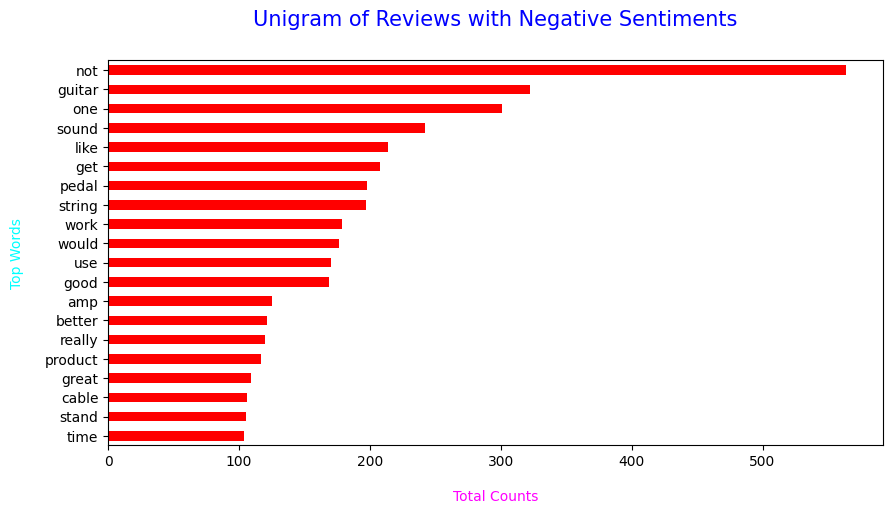

In [34]:
# Finding Unigram
words = Gram_Analysis(Negative["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Unigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

####Bigram of Reviews Based On Sentiments

#####Positive Sentiment

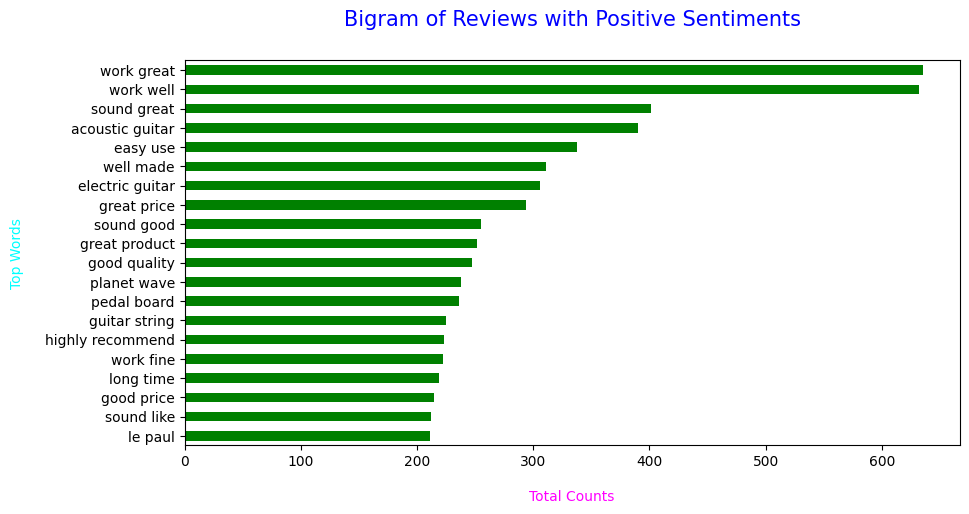

In [35]:
# Finding Bigram
words = Gram_Analysis(Positive["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Bigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

#####Neutral Sentiment

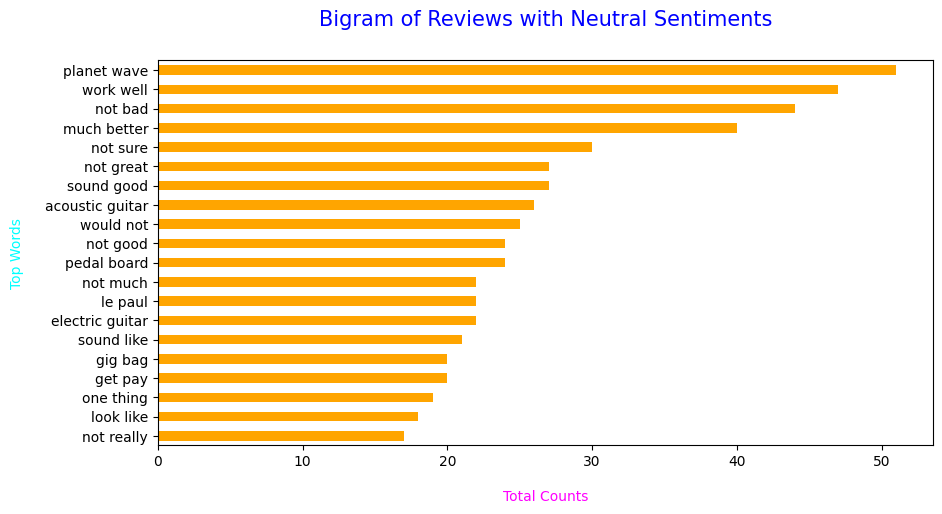

In [36]:
# Finding Bigram
words = Gram_Analysis(Neutral["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Bigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

#####Negative Sentiment

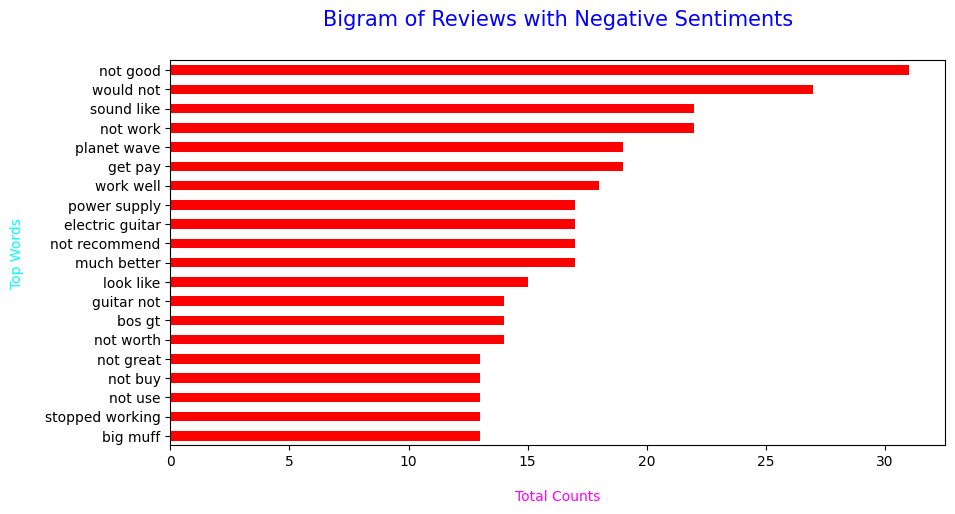

In [37]:
# Finding Bigram
words = Gram_Analysis(Negative["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Bigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

####Trigram of Reviews Based On Sentiments

#####Positive Sentiment

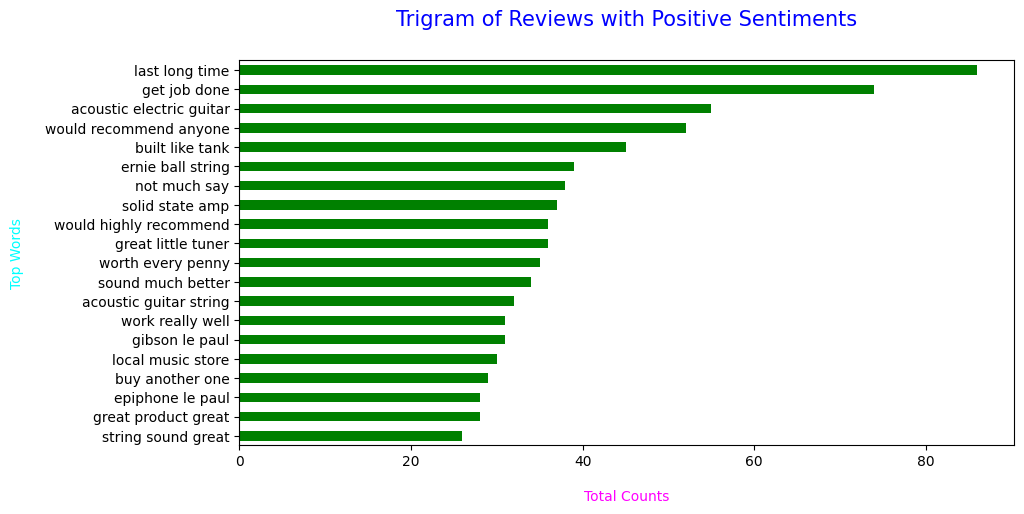

In [38]:
# Finding Trigram
words = Gram_Analysis(Positive["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Trigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()


#####Neutral Sentiment

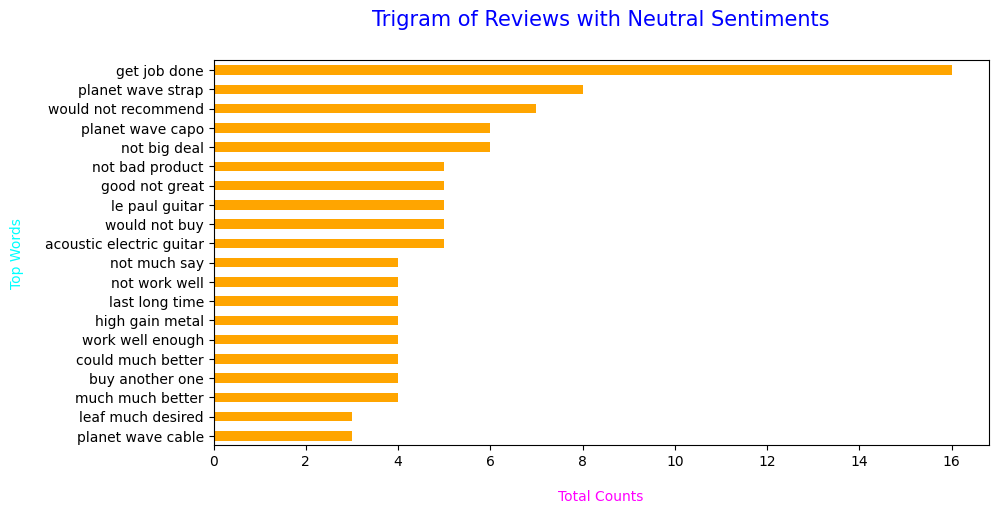

In [39]:
# Finding Trigram
words = Gram_Analysis(Neutral["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Trigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

#####Negative Sentiment

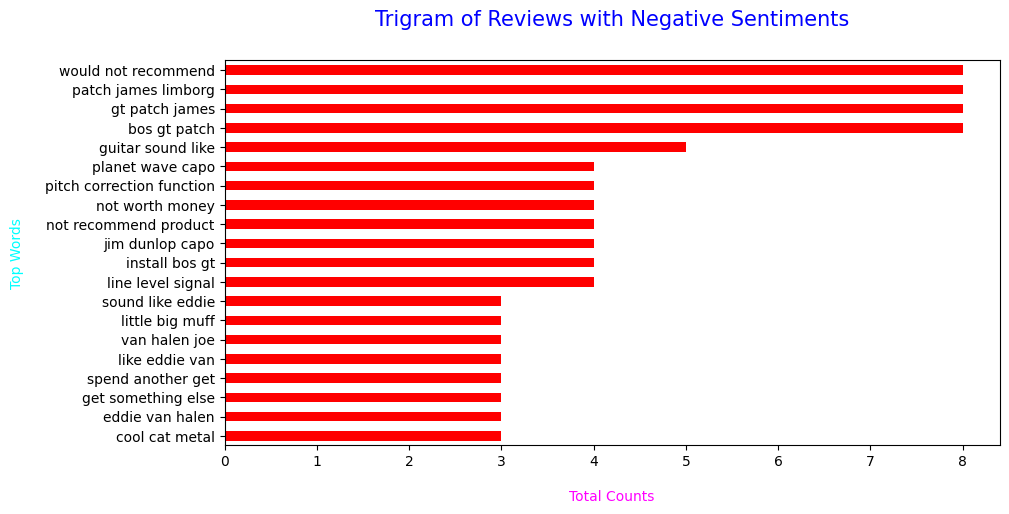

In [40]:
# Finding Trigram
words = Gram_Analysis(Negative["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Trigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

###Word Clouds

####Word Cloud of Reviews with Sentiments

#####Positive Sentiment

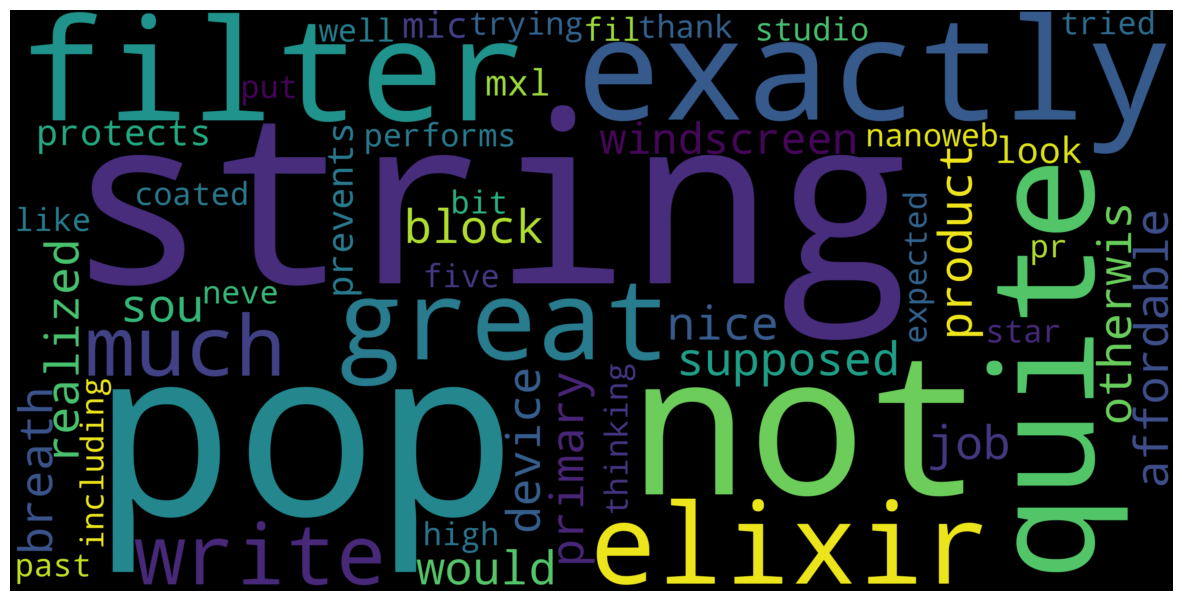

In [41]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Positive["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

#####Neutral Sentiment

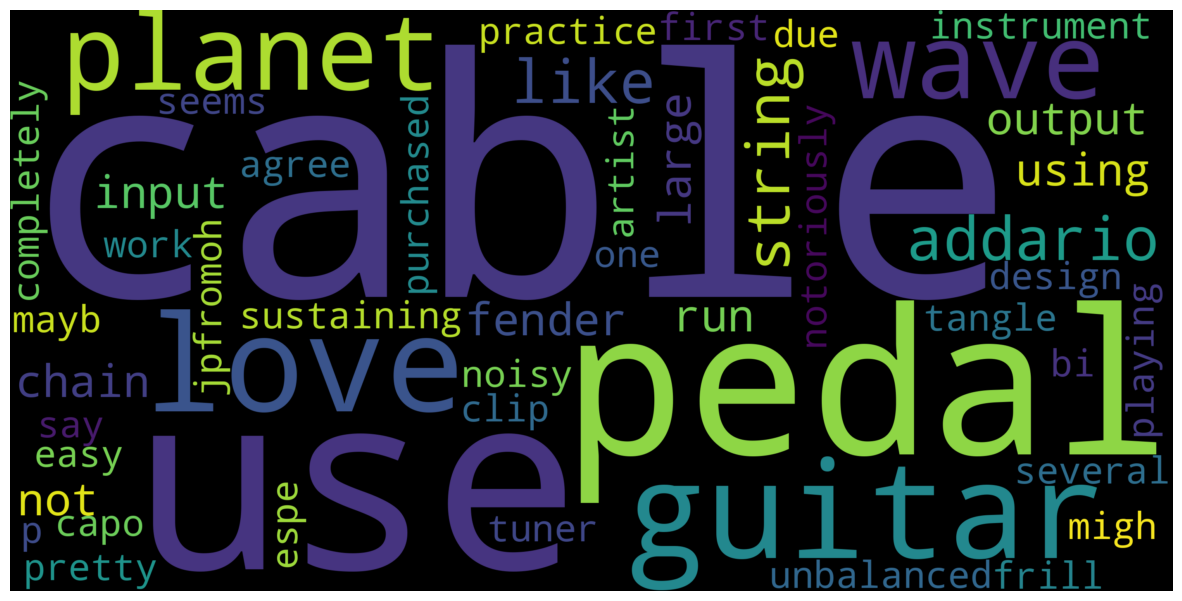

In [42]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Neutral["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

#####Negative Sentiment

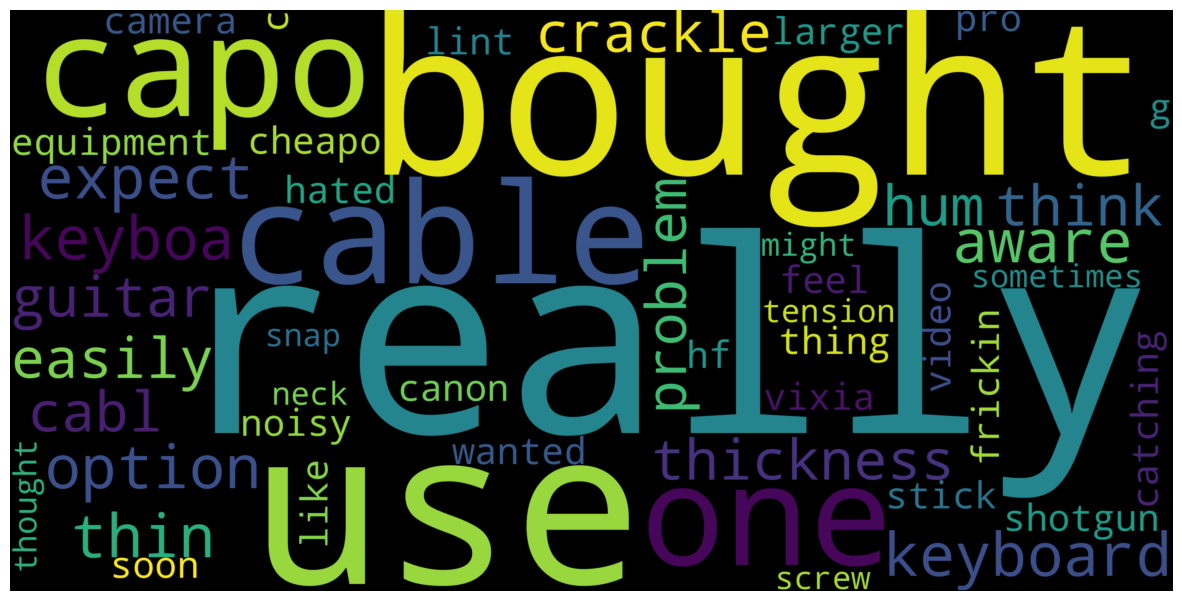

In [43]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Negative["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

##Predictive Modeling

In [50]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.4 MB/s eta 0:00:00


In [47]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 7.6 MB/s eta 0:00:00


In [73]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import catboost as cb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

###Model Training

In [52]:
Columns = ["reviewerID", "asin", "reviewerName", "helpful", "unixReviewTime", "reviewTime", "polarity", "length", "word_counts", "overall"]
dataset.drop(columns = Columns, axis = 1, inplace = True)

In [53]:
dataset.head()

,reviews,sentiment
0,not much write exactly supposed filter pop sou...,Positive
1,product exactly quite affordable not realized ...,Positive
2,primary job device block breath would otherwis...,Positive
3,nice windscreen protects mxl mic prevents pop ...,Positive
4,pop filter great look performs like studio fil...,Positive


In [54]:
Encoder = LabelEncoder()
dataset["sentiment"] = Encoder.fit_transform(dataset["sentiment"])

In [55]:
dataset["sentiment"].value_counts()

,count
sentiment,
2,9022
1,772
0,467


####TF-IDF Vectorizer

In [56]:
# Defining our vectorizer with total words of 5000 and with bigram model
TF_IDF = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))

# Fitting and transforming our reviews into a matrix of weighed words
# This will be our independent features
X = TF_IDF.fit_transform(dataset["reviews"])

# Check our matrix shape
X.shape

(10261, 5000)

In [59]:
# Declaring our target variable
y = dataset["sentiment"]

####Resampling Our Dataset

In [60]:
Counter(y)

Counter({2: 9022, 1: 772, 0: 467})

####SMOTE

In [62]:
from imblearn.over_sampling import SMOTE
Balancer = SMOTE(random_state = 42)
X_final, y_final = Balancer.fit_resample(X, y)

In [63]:
Counter(y_final)

Counter({2: 9022, 1: 9022, 0: 9022})

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.25, random_state = 42)

#### Model Selection

In [ ]:
# List of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss'),
    "CatBoost": cb.CatBoostClassifier(verbose=0)
}

# Function to train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}
    predictions = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        predictions[name] = y_pred

        print(f"{name} results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}\n")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return results, predictions


###Model Evaluation

Logistic Regression results:
Accuracy: 0.9014
Precision: 0.9070
Recall: 0.9016
F1 Score: 0.9004



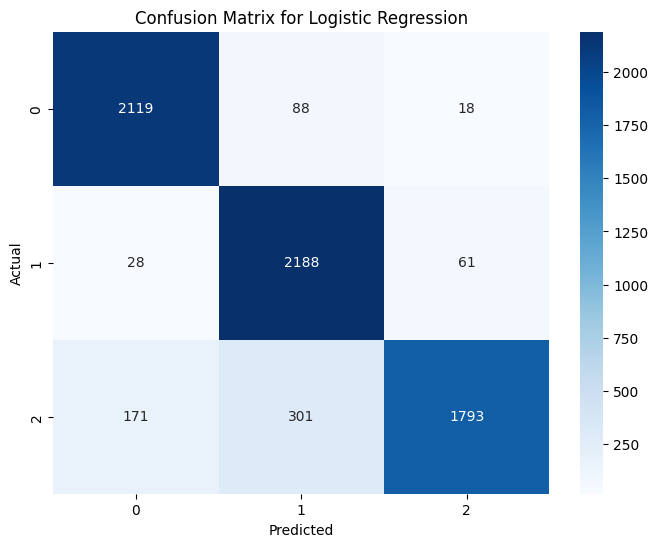

Decision Tree results:
Accuracy: 0.8927
Precision: 0.8999
Recall: 0.8932
F1 Score: 0.8908



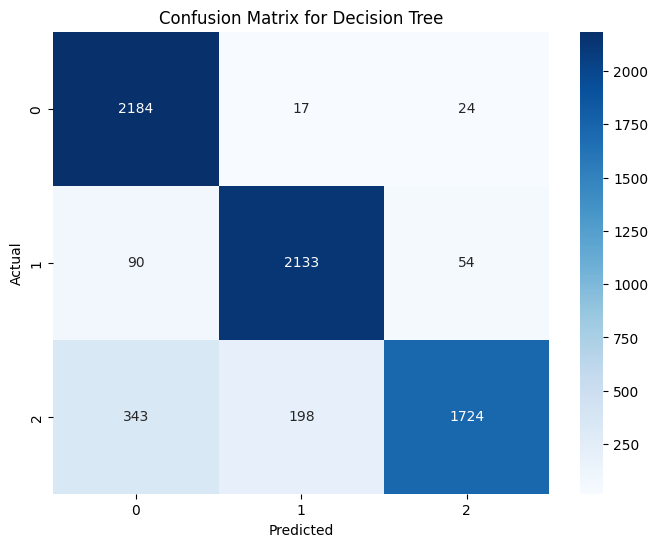

Random Forest results:
Accuracy: 0.9196
Precision: 0.9274
Recall: 0.9200
F1 Score: 0.9185



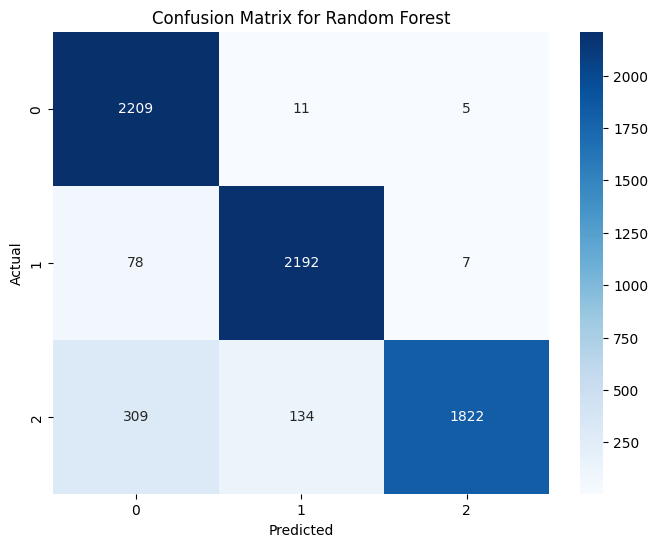

AdaBoost results:
Accuracy: 0.5286
Precision: 0.6438
Recall: 0.5272
F1 Score: 0.5211



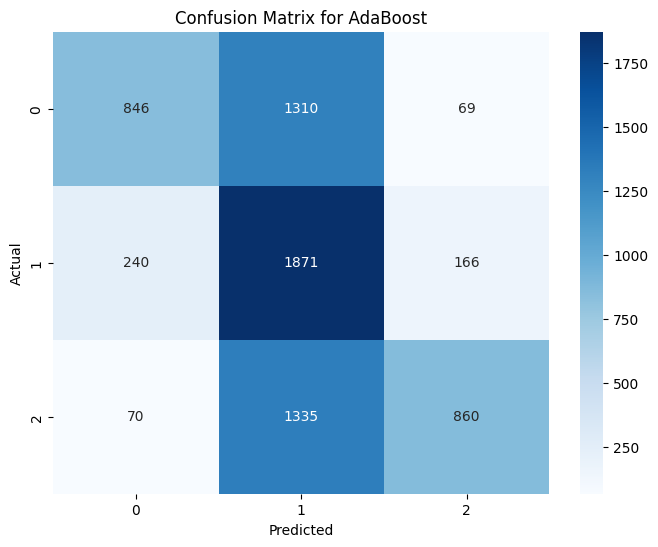

Gradient Boosting results:
Accuracy: 0.6693
Precision: 0.7289
Recall: 0.6686
F1 Score: 0.6701



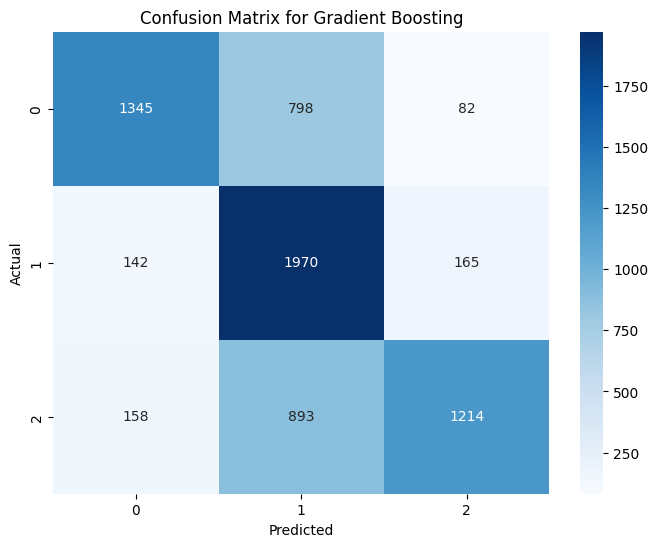

XGBoost results:
Accuracy: 0.8351
Precision: 0.8471
Recall: 0.8351
F1 Score: 0.8356



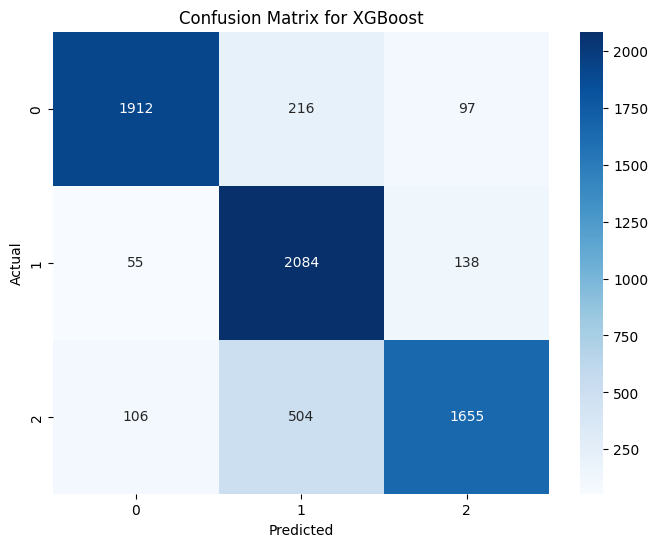

CatBoost results:
Accuracy: 0.8679
Precision: 0.8728
Recall: 0.8681
F1 Score: 0.8674



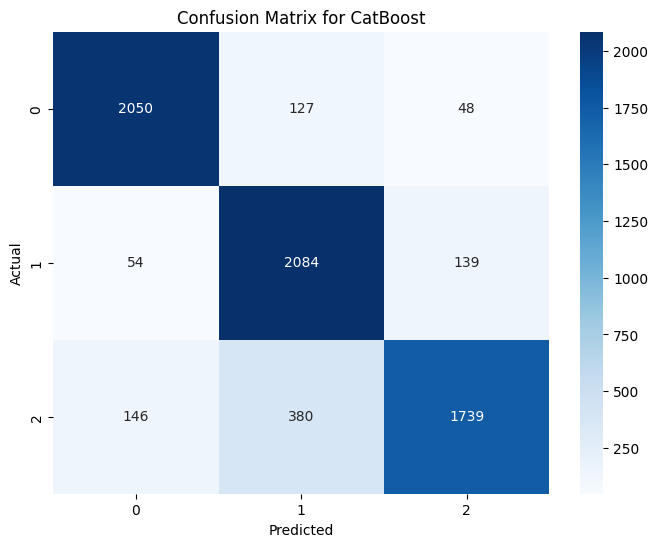

In [79]:
# Train and evaluate the models
results, predictions = train_and_evaluate(models, X_train, X_test, y_train, y_test)

In [80]:
# Display results in a table format
results_df = pd.DataFrame(results)
results_df

,Logistic Regression,Decision Tree,Random Forest,AdaBoost,Gradient Boosting,XGBoost,CatBoost
accuracy,0.901433,0.892715,0.919610,0.528595,0.669277,0.835082,0.867888
precision,0.907000,0.899897,0.927445,0.643842,0.728890,0.847073,0.872780
recall,0.901628,0.893160,0.919965,0.527204,0.668550,0.835083,0.868119
f1_score,0.900400,0.890761,0.918519,0.521070,0.670084,0.835553,0.867426


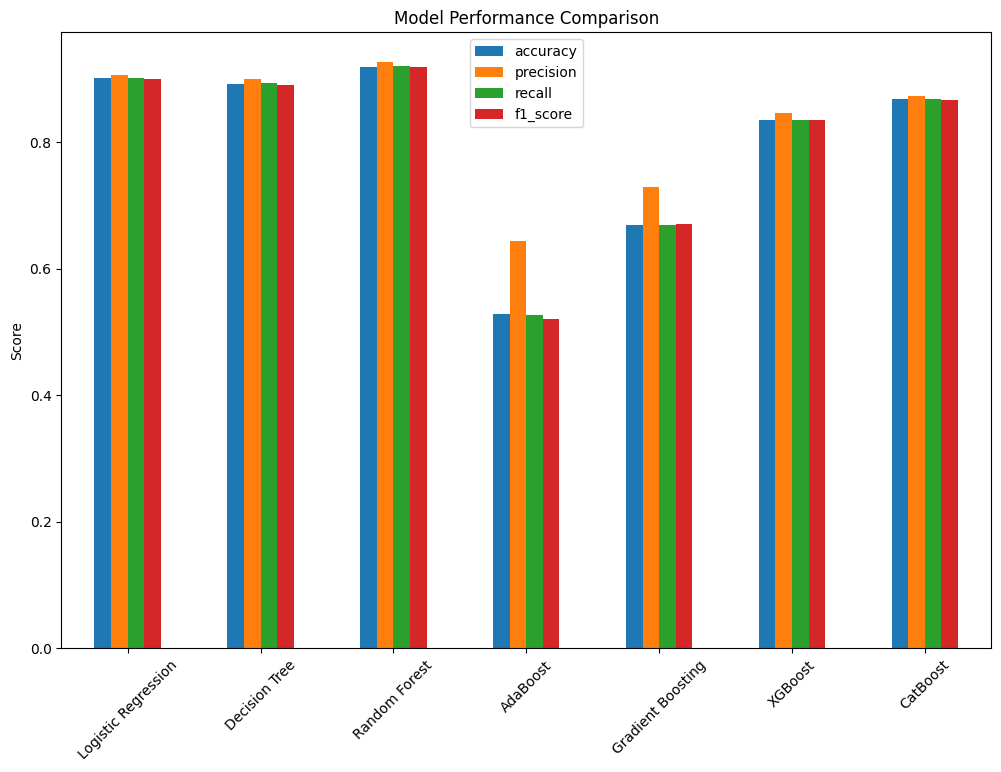

In [81]:
# Plotting the results
results_df = pd.DataFrame(results).T
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

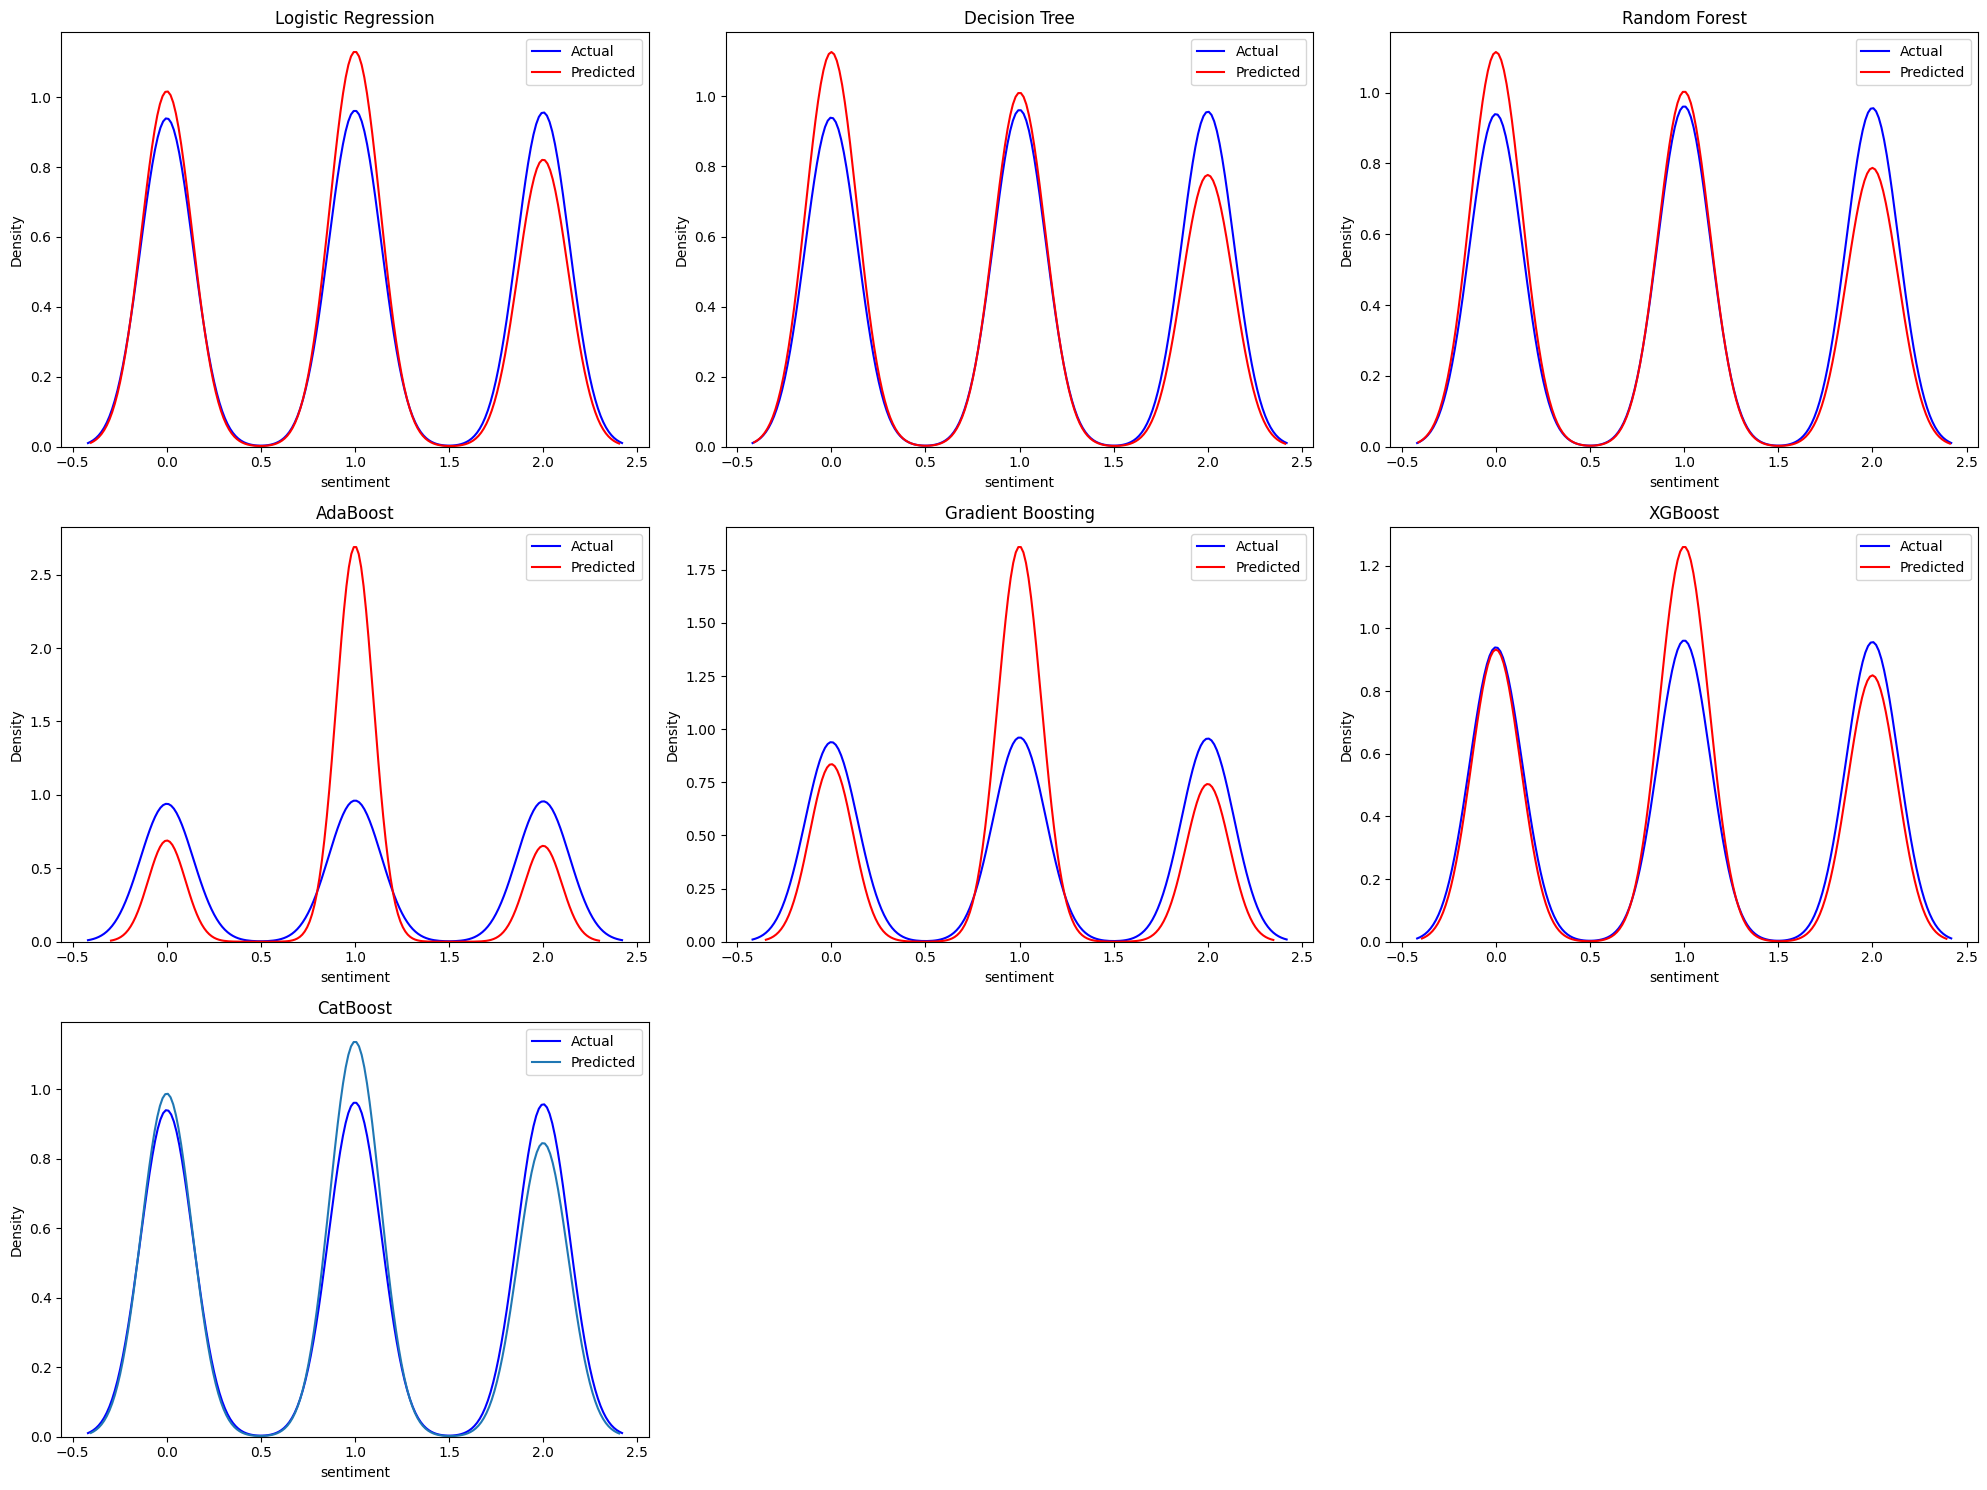

In [84]:
# Plotting the distributions
fig, ax = plt.subplots(3, 3, figsize=(20, 15))  # 3x3 grid for 7 models

model_names = list(models.keys())

for i, name in enumerate(model_names):
    sns.kdeplot(y_test, ax=ax[i//3, i%3], label='Actual', color='blue')
    sns.kdeplot(predictions[name], ax=ax[i//3, i%3], label='Predicted', color='red')
    ax[i//3, i%3].set_title(name)
    ax[i//3, i%3].legend()  # Add legend to each subplot

# Remove empty subplots if any
for j in range(len(model_names), 9):
    fig.delaxes(ax[j//3, j%3])

plt.tight_layout()
plt.show()

###Model Hyperparameter Tuning

In [90]:
from sklearn.model_selection import RandomizedSearchCV
# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters from Randomized Search:", random_search.best_params_)

# Best model
best_rf_random = random_search.best_estimator_
best_rf_random

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters from Randomized Search: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


RandomForestClassifier(bootstrap=False, min_samples_split=5, random_state=42)

In [91]:
# Evaluate the tuned model on the test set
y_pred = best_rf_random.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Tuned Random Forest Accuracy with Randomized Search: {accuracy:.4f}")

Tuned Random Forest Accuracy with Randomized Search: 0.9353


In [92]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9396
Recall: 0.9356
F1 Score: 0.9348


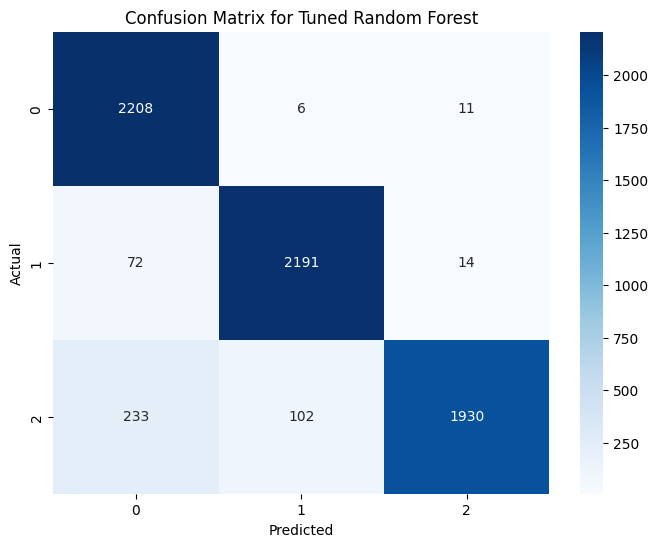

In [95]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Tuned Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##Conclusion

 Most of the transactions made are related to guitars or other string-based instruments. We can say that guitar got a really high attention from the customers' pool and the sellers can emphasize their products on this instruments.

The Random Forest model underwent hyperparameter tuning using Randomized Search, evaluating 100 combinations over 5-fold cross-validation, totaling 500 fits. The best parameters identified were: 100 estimators, `min_samples_split` of 5, `min_samples_leaf` of 1, `max_features` set to 'sqrt', `max_depth` as None, and `bootstrap` set to False.

After tuning, the model was tested on the dataset. The evaluation showed strong performance:

- **Precision:** 0.9396
- **Recall:** 0.9356
- **F1 Score:** 0.9348

These metrics indicate that the model is accurate and balanced in predicting sentiment classes.
